In [1]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [2]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=512)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [3]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomHeight(factor=0.2),
        layers.RandomWidth(factor=0.2),
    ]
)

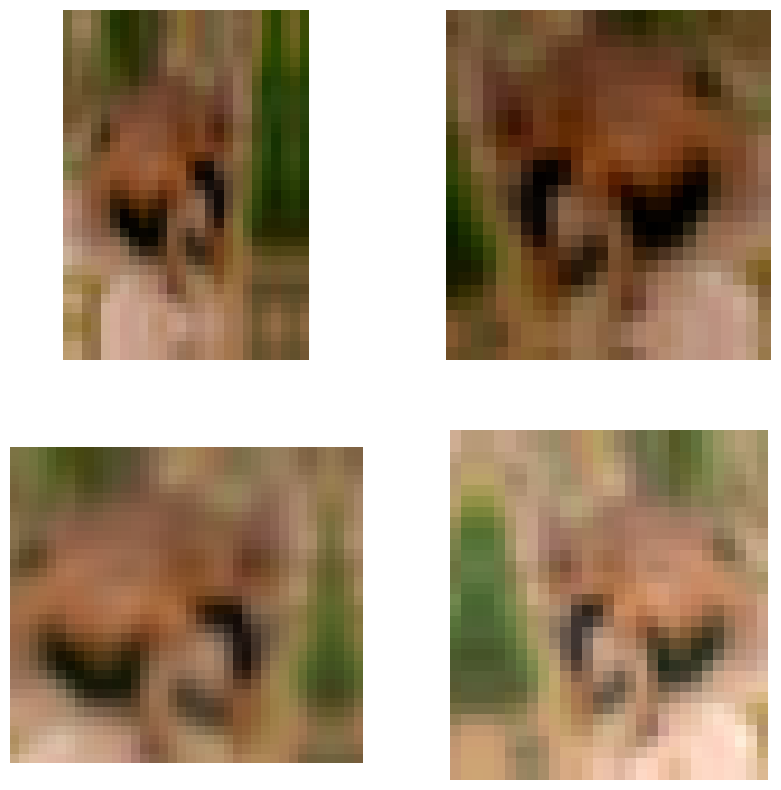

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Nesta fase do nosso código tivemos de abdicar da cama densa com L2 devido a um problema de conversão por parte do modelo de h5 para json, impedindo que o nosso modelo fosse, posteriormente, utilizado na nossa aplicação WEB.
Decidimos assim abdicar desta camada.

In [5]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
#x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                        

In [7]:
history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset)

Epoch 1/30
79/79 [==============================] - 18s 224ms/step - loss: 2.2953 - acc: 0.1101 - val_loss: 2.2807 - val_acc: 0.1239
Epoch 2/30
79/79 [==============================] - 17s 217ms/step - loss: 2.2541 - acc: 0.1477 - val_loss: 2.2016 - val_acc: 0.1808
Epoch 3/30
79/79 [==============================] - 18s 223ms/step - loss: 2.1831 - acc: 0.1771 - val_loss: 2.1364 - val_acc: 0.1966
Epoch 4/30
79/79 [==============================] - 18s 227ms/step - loss: 2.1262 - acc: 0.1946 - val_loss: 2.1130 - val_acc: 0.1965
Epoch 5/30
79/79 [==============================] - 18s 230ms/step - loss: 2.0782 - acc: 0.2168 - val_loss: 2.0357 - val_acc: 0.2511
Epoch 6/30
79/79 [==============================] - 19s 240ms/step - loss: 2.0330 - acc: 0.2376 - val_loss: 2.0599 - val_acc: 0.2478
Epoch 7/30
79/79 [==============================] - 24s 303ms/step - loss: 1.9953 - acc: 0.2556 - val_loss: 2.0355 - val_acc: 0.2285
Epoch 8/30
79/79 [==============================] - 47s 587ms/step - 

In [8]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_3_data_augmentation.h5')

79/79 [==============================] - 2s 28ms/step - loss: 1.4867 - acc: 0.4539
val_acc: 0.453900009393692


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


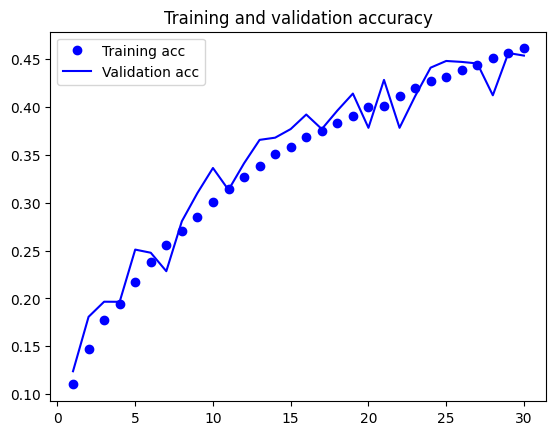

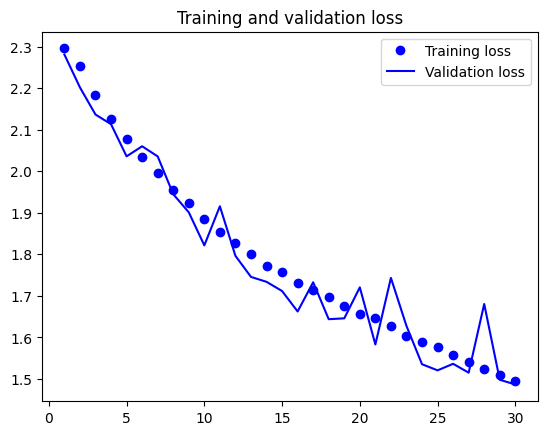

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

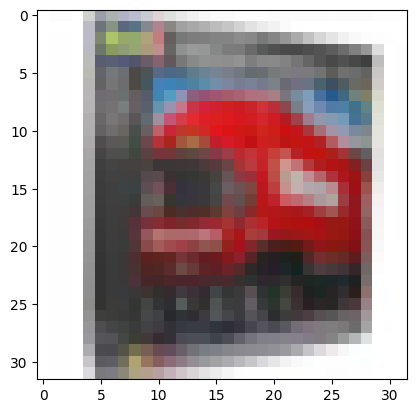

1/1 [==============================] - 0s 221ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [0.01694334 0.1866881  0.00753382 0.01929704 0.01132009 0.01259663
 0.03065705 0.01908742 0.07801766 0.6178589 ]


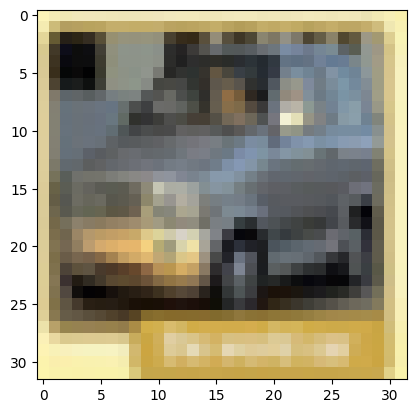

1/1 [==============================] - 0s 39ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 001_automobile ---- Predicted class: Truck
Predicted probabilities: [0.02447478 0.2126002  0.0175309  0.01816468 0.02894558 0.01497438
 0.09698579 0.07096418 0.03026978 0.48508978]


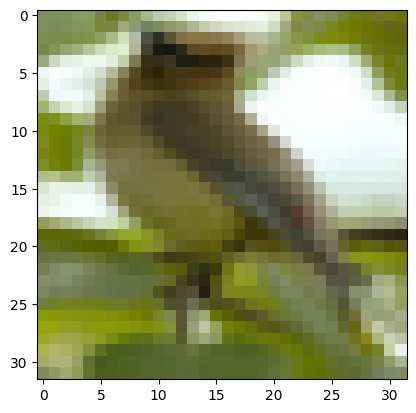

1/1 [==============================] - 0s 19ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Horse
Predicted probabilities: [0.00437641 0.00073098 0.10447468 0.10316814 0.10602373 0.03531761
 0.0454076  0.5771346  0.00168149 0.02168483]


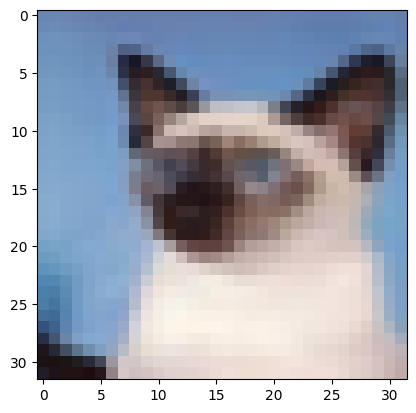

1/1 [==============================] - 0s 40ms/step
Predicted vector: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Bird
Predicted probabilities: [0.05342828 0.00192745 0.34730417 0.1179353  0.13692223 0.07945228
 0.00979128 0.228818   0.0217844  0.00263658]


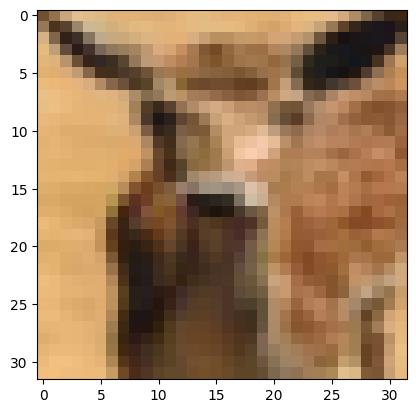

1/1 [==============================] - 0s 60ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Dog
Predicted probabilities: [0.00182602 0.00110955 0.13630794 0.2865392  0.05722991 0.2947861
 0.07258775 0.1442737  0.0031864  0.00215355]


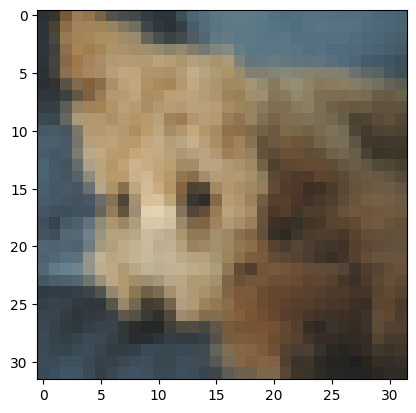

1/1 [==============================] - 0s 17ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [1.5397628e-03 3.4385137e-04 1.3975440e-01 2.8714898e-01 1.2094485e-01
 3.5285646e-01 5.5656821e-02 3.8740944e-02 2.0722686e-03 9.4171212e-04]


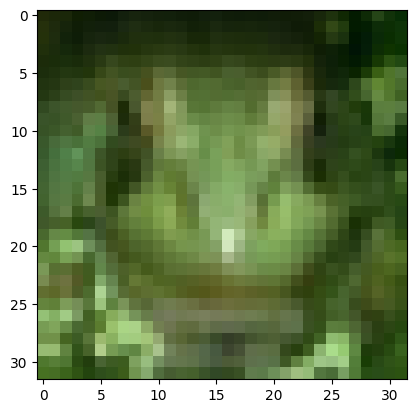

1/1 [==============================] - 0s 28ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Frog
Predicted probabilities: [0.00349047 0.00140353 0.04843836 0.07087749 0.24093252 0.03225004
 0.5365456  0.05177624 0.00056103 0.0137247 ]


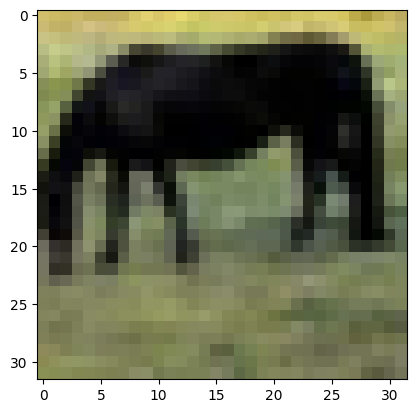

1/1 [==============================] - 0s 29ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Horse
Predicted probabilities: [0.00259624 0.00094707 0.05239248 0.11405231 0.07041711 0.03134249
 0.06143439 0.65194845 0.00178507 0.01308439]


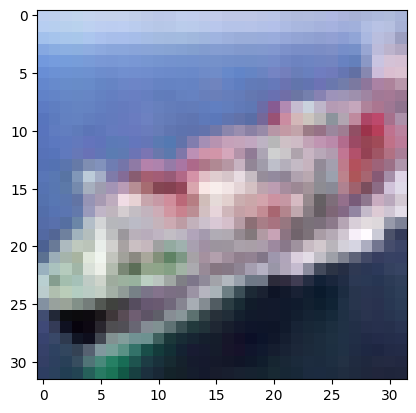

1/1 [==============================] - 0s 18ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Actual class: 008_ship ---- Predicted class: Ship
Predicted probabilities: [1.2631638e-01 4.3101374e-02 3.0290436e-03 3.3898030e-03 4.3338072e-03
 1.6520667e-03 4.3846396e-04 8.3749101e-04 7.4016917e-01 7.6732486e-02]


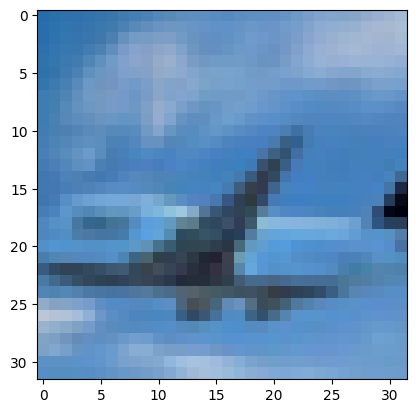

1/1 [==============================] - 0s 21ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [0.61689144 0.01605666 0.06429243 0.00931966 0.04064405 0.00566138
 0.00142681 0.00627029 0.21828134 0.02115598]


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo salvo
model = keras.models.load_model('models/projeto_3_data_augmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de arquivos de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a predição
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a predição
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de predição
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # Mapeamento de índices de classes para rótulos
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém o rótulo da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de rótulos para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predições para cada rótulo na lista
for label in labels:
    predict_image_class(label)